In [1]:
  # Import libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scikitplot as skplt

from plotly.offline import iplot

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from tensorflow import keras
from tensorflow.keras import initializers, layers

## Load dataset relating items and skills

In [2]:
datas = list()
originals = list()
masks = list()

for i in range(100):
    data = pd.read_csv('output_data/50_missing/y/Y_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None)
    data_train = np.ones(data.shape)
    data_train[data < 0.5] = 0.
    datas.append(data_train)
    original = pd.read_csv('input_data/y/Yrep' + str(i+1) + '.csv', sep=';', header=None)
    originals.append(original.values.reshape((180, 10000)).transpose()[:8000, :])
    masks.append(pd.read_csv('output_data/50_missing/masked/Masked_rep' + str(i+1) + '_50_missing.csv', sep=';', header=None))


In [3]:
Q = pd.read_csv('input_data/qmatrix/Qmatrix.csv', sep=';', header=None)
Q = Q.T
print(Q.shape)

(21, 180)


In [4]:
for d, m, o in zip(datas, masks, originals):

    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m.iloc[i, j] != -1 and d[i, j] != o[i, j]:
                d[i, j] = o[i, j]

In [5]:
print(datas)

[array([[0., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.]]), array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]]), array([[1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 1., 0.

In [6]:
# Set stats and skills
num_stats = datas[0].shape[1] 
num_skills = 21

intermediate_dim=40

# Number of subjects
N = datas[0].shape[0]
# Training number
tr = N
batch_size = 50
epochs = 100

In [7]:
""" Helper functions """

# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(num_skills): 
    for i in range(num_stats):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


In [8]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(keras.Model):
    """Maps items respone to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=num_skills, intermediate_dim=intermediate_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="tanh")
        self.dense_mean = layers.Dense(latent_dim
                                       #, kernel_initializer=initializers.Zeros()
                                       )
        self.dense_log_var = layers.Dense(latent_dim
                                          #, kernel_initializer=initializers.Zeros()
                                          )
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        #tf.print(tf.math.reduce_mean(z_mean))
        z_log_var = self.dense_log_var(x)
        #tf.print(tf.math.reduce_mean(tf.math.exp(0.5 * z_log_var)))

        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(keras.Model):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=num_skills, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(latent_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim
                                         , activation="sigmoid"
                                         , kernel_constraint=q_constraint
                                         #, kernel_initializer=initializers.Ones()
                                         #, bias_initializer=initializers.Zeros()
                                         )

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        return self.dense_output(inputs)



class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=intermediate_dim,
        latent_dim=num_skills,
        name="autoencoder"
    ):
        super(VariationalAutoEncoder, self).__init__(name=name)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim)

    def call(self, inputs):
        self.z_mean, self.z_log_var, self.z = self.encoder(inputs)
        reconstructed = self.decoder(self.z)
        return reconstructed

    # Loss function
    def vae_loss(self, input, output):
        cross_entropy_loss = (num_stats / 1.0) * keras.losses.binary_crossentropy(input, output)
        kl_loss = -0.5 * tf.reduce_mean(self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var) + 1, axis=-1)
        return cross_entropy_loss + kl_loss

    # Get weights
    def _get_weights(self):
        return self.decoder.trainable_weights

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

In [9]:
thetas = pd.DataFrame()
thetas_logvar = pd.DataFrame()
discrs_hat = pd.DataFrame()
diffs = pd.DataFrame()
preds = pd.DataFrame()

for i in range(100):
    
    vae_q = VariationalAutoEncoder(num_stats, intermediate_dim, num_skills)

    # Optimizer
    #opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    data_train = datas[i]
    
    history = vae_q.fit(data_train,
                        data_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True)
    # validation_split=0.2
    ba = 0
    for value in history.history['binary_accuracy']:
        ba += value
    print("Binary Accuracy: %.4f" % (ba / epochs))

    encoder = vae_q.get_encoder()
    decoder = vae_q.get_decoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(data_train)
    pred = decoder.predict_step(z_pred)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, data_train, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/50_missing/theta/thetas_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', index=False)
    thetas['Rep' + str(i+1)] = theta_hat
    thetas_logvar['Rep' + str(i+1)] = log_var_theta_hat

    discr = pd.DataFrame(discr)
    discr.to_csv('output_data/50_missing/a/discr_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None, index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.to_csv('output_data/50_missing/a/discr_hat_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None, index=False)
    discrs_hat['Rep' + str(i+1)] = discr_hat

    # Save a estimated replication TRANSPOSED
    discr_hat_GUI.T.to_csv(
        'output_data/50_missing/a/discr_hat_rep' + str(i+1) + '_transformer_50_missing_TRANSPOSED.csv', sep=';', header=None, index=False)

    negative_diff.to_csv('output_data/50_missing/b/diff_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None, index=False)
    diffs['Rep' + str(i+1)] = np.negative(weights[1].numpy())

    preds['Rep' + str(i+1)] = pred.numpy().flatten()


Epoch 1/100


2023-07-25 15:03:53.012103: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - 1s 776us/step - loss: 122.1288 - binary_accuracy: 0.6265
Epoch 2/100
160/160 [==============================] - 0s 777us/step - loss: 116.3144 - binary_accuracy: 0.6648
Epoch 3/100
160/160 [==============================] - 0s 787us/step - loss: 111.3961 - binary_accuracy: 0.6846
Epoch 4/100
160/160 [==============================] - 0s 830us/step - loss: 106.9394 - binary_accuracy: 0.6987
Epoch 5/100
160/160 [==============================] - 0s 747us/step - loss: 102.5971 - binary_accuracy: 0.7206
Epoch 6/100
160/160 [==============================] - 0s 786us/step - loss: 97.7430 - binary_accuracy: 0.7418
Epoch 7/100
160/160 [==============================] - 0s 811us/step - loss: 93.6656 - binary_accuracy: 0.7563
Epoch 8/100
160/160 [==============================] - 0s 772us/step - loss: 90.7220 - binary_accuracy: 0.7658
Epoch 9/100
160/160 [==============================] - 0s 771us/step - loss: 88.7769 - binary_accuracy: 0.7715
Epoch 10

In [10]:
binary_preds = np.ones(preds.shape)
binary_preds[preds.values < 0.5] = 0.

In [11]:
binary_preds = pd.DataFrame(binary_preds, columns=preds.columns)

In [12]:
# a artificial
a_values = pd.read_csv('input_data/a/a_values.csv', sep=';', header=None)
#a_rep_gui = pd.read_csv('output/discr_hat_transformer_10_missing_TRANSPOSED.csv', sep=';', header=0)

# b artificial
b_values = pd.read_csv('input_data/b/b_values.csv', sep=';', header=None)
#b_rep_gui = pd.read_csv('output/diff_transformer_10_missing.csv', sep=';', header=0)

# theta artificial
theta_values = pd.read_csv('input_data/theta/theta_values.csv', sep=';', header=None)
#theta_rep_gui = pd.read_csv('output/thetas_transformer_10_missing.csv', sep=';', header=0)

## Discriminations

In [13]:
cols = ['a_values']

a_results = pd.DataFrame(columns=cols)

a_results['a_values'] = a_values

a_results = pd.concat([a_results, discrs_hat], axis=1)

In [14]:
a_results['Bias'] = np.sum(a_values.values - discrs_hat.values, axis=1)/100
a_results['RMSE'] = np.sqrt(np.sum((a_values.values - discrs_hat)**2, axis=1)/100)
a_results['Abs Bias'] = np.sum(np.abs(a_values.values - discrs_hat.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/1112998409.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/1112998409.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/1112998409.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [15]:
corrs = []

for column in discrs_hat:
    corrs.append(a_results['a_values'].corr(discrs_hat['Rep1']))

a_results['Corr'] = ""
a_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/741033095.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/741033095.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
a_results

,a_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,1.164934,1.078071,1.013741,1.015170,0.960552,0.992180,0.987086,1.025181,0.977226,0.944085,...,1.019155,0.993245,1.015266,0.976847,1.029733,0.974543,0.173881,0.176373,0.173881,0.708732
1,0.761002,0.469766,0.478314,0.457416,0.505637,0.501324,0.504534,0.487679,0.477202,0.474618,...,0.492673,0.498286,0.476238,0.499773,0.490704,0.484623,0.273396,0.273834,0.273396,
2,0.823079,0.521416,0.558668,0.521518,0.564168,0.556046,0.517246,0.541233,0.510251,0.556258,...,0.458327,0.566069,0.526647,0.589212,0.574656,0.546880,0.281181,0.282562,0.281181,
3,1.507663,1.200993,1.119557,1.166343,1.117676,1.110790,1.127205,1.100281,1.111337,1.128507,...,1.109290,1.116658,1.151353,1.058318,1.098513,1.142231,0.372450,0.373792,0.372450,
4,0.733496,0.462543,0.485916,0.446215,0.460725,0.463551,0.490799,0.467055,0.464221,0.468881,...,0.504436,0.456876,0.470088,0.481134,0.445182,0.501261,0.262842,0.263572,0.262842,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.819945,0.875222,0.858818,0.791752,0.969085,0.820552,0.888915,0.781651,0.892997,0.786340,...,0.911708,0.937044,0.809483,0.834611,0.758395,0.803564,-0.013067,0.054996,0.043045,
296,1.348967,0.878135,0.977534,0.852802,1.024697,0.985965,0.901519,0.896486,0.838247,0.957783,...,0.888745,0.962216,0.812723,0.918391,0.899688,0.908452,0.432720,0.436291,0.432720,
297,0.774595,0.576422,0.690415,0.753621,0.661861,0.770891,0.603381,0.650312,0.626746,0.735855,...,0.597544,0.647860,0.783689,0.710887,0.729410,0.650929,0.079506,0.107266,0.088161,
298,1.662084,1.015750,1.326841,1.252371,1.313096,1.278244,1.135620,1.298661,1.099576,1.332715,...,1.035483,1.161253,1.210271,1.245496,1.231142,1.105479,0.455290,0.467394,0.455290,


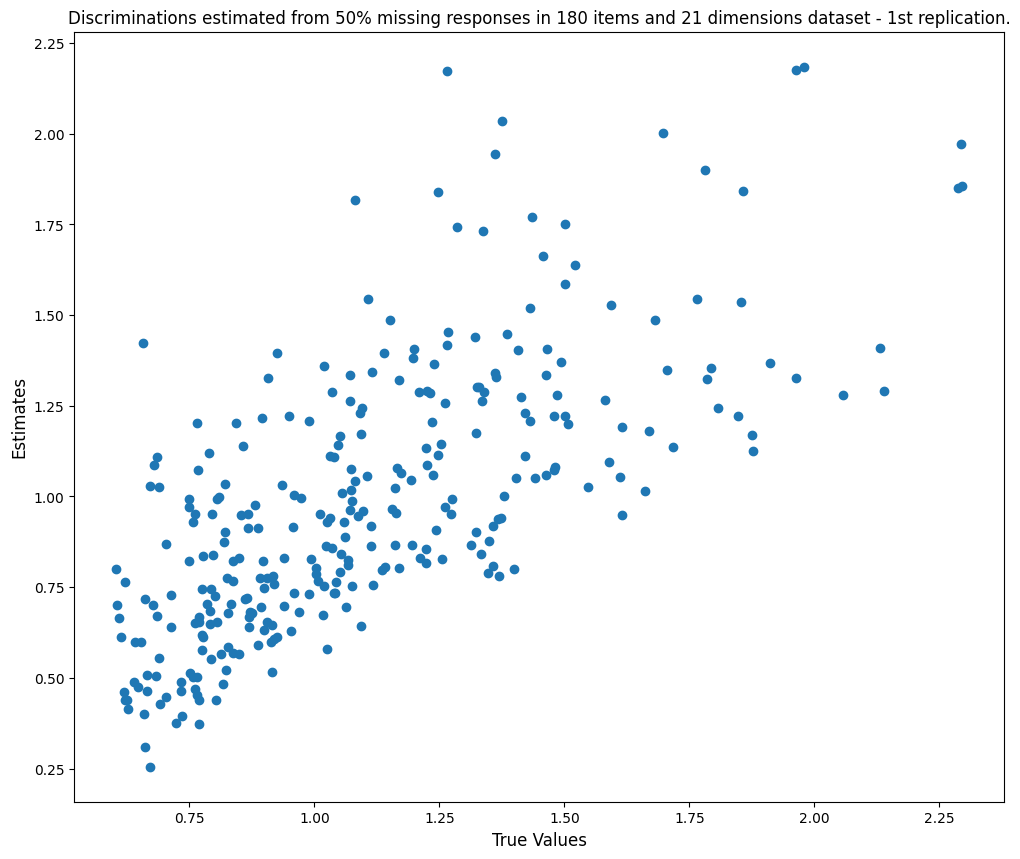

In [17]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=a_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Discriminations estimated from 50% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [18]:
a_results.to_csv('output_data/50_missing/a/a_results.csv', sep=';', header=True, index=False)

## Difficulties

In [19]:
cols = ['b_values']

b_results = pd.DataFrame(columns=cols)

b_results['b_values'] = b_values

b_results = pd.concat([b_results, diffs], axis=1)

In [20]:
b_results['Bias'] = np.sum(b_values.values - diffs.values, axis=1)/100
b_results['RMSE'] = np.sqrt(np.sum((b_values.values - diffs)**2, axis=1)/100)
b_results['Abs Bias'] = np.sum(np.abs(b_values.values - diffs.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/3793169349.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/3793169349.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/3793169349.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [21]:
corrs = []

for column in diffs:
    corrs.append(b_results['b_values'].corr(diffs[column]))

b_results['Corr'] = ""
b_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/713609593.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/713609593.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
b_results

,b_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-0.516250,-0.950571,-1.111679,-0.993354,-0.855831,-0.876172,-1.098551,-0.987089,-1.103879,-0.897668,...,-1.222970,-0.916857,-1.159497,-0.802895,-0.828205,-1.161213,0.488521,0.509012,0.488521,0.956254
1,-0.403987,-0.465457,-0.580694,-0.537177,-0.452659,-0.483874,-0.625478,-0.554824,-0.595935,-0.531302,...,-0.662154,-0.498397,-0.574786,-0.485200,-0.453428,-0.630151,0.145593,0.161195,0.145593,
2,-1.797941,-3.071237,-2.401806,-2.947756,-2.333046,-2.968940,-2.328261,-2.347486,-2.234282,-2.881627,...,-2.278158,-2.260931,-2.861109,-2.295649,-2.247623,-2.367844,0.806472,0.853855,0.806472,
3,0.763532,0.520543,1.873076,0.637613,2.112103,0.518518,2.141604,1.851244,2.083827,0.620638,...,1.843788,2.068526,0.880897,2.136257,2.154587,1.751094,-0.663813,0.917033,0.762171,
4,-0.787187,-1.100427,-1.133445,-1.048901,-1.301292,-1.020773,-1.219369,-1.094398,-1.080709,-0.909343,...,-1.022334,-1.214960,-1.156955,-1.359918,-1.158332,-1.255337,0.315357,0.335650,0.315357,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.660764,0.476917,0.258075,0.178521,0.074801,0.216909,0.290595,-0.004955,0.382662,-0.058049,...,0.448543,0.187718,0.136923,-0.090731,-0.107956,0.532245,0.435985,0.468111,0.435985,
176,0.928390,0.821803,0.713322,0.567240,0.582356,0.630340,0.675324,0.604869,0.844256,0.562512,...,0.756580,0.663619,0.739255,0.550403,0.523482,0.759941,0.239258,0.253402,0.239258,
177,-2.073206,-2.870077,-2.842349,-2.793254,-2.856020,-2.828676,-2.799598,-2.874485,-2.777865,-2.802050,...,-2.775687,-2.737321,-2.745631,-2.824247,-2.762756,-2.856151,0.732598,0.734077,0.732598,
178,0.197686,0.337158,0.314528,0.306695,0.317432,0.359356,0.391378,0.365481,0.392507,0.345459,...,0.359486,0.359725,0.357425,0.323155,0.358202,0.344054,-0.148319,0.150100,0.148319,


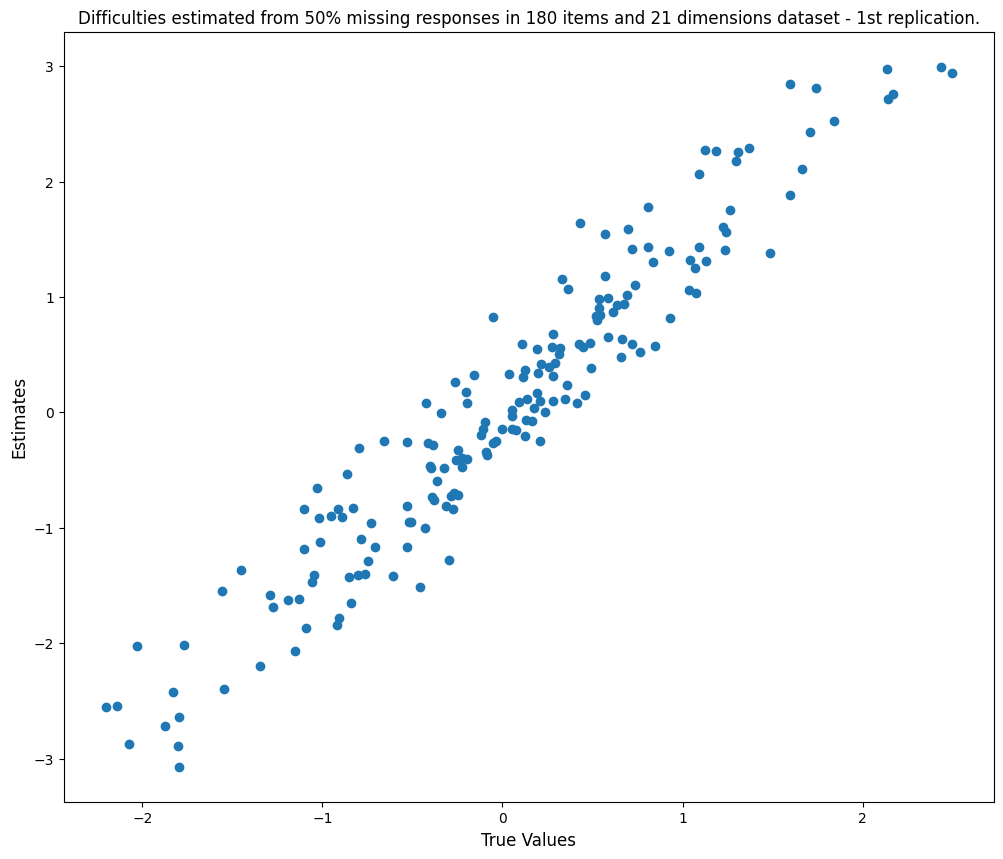

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values, y=b_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Difficulties estimated from 50% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [24]:
b_results.to_csv('output_data/50_missing/b/b_results.csv', sep=';', header=True, index=False)

## Thetas

In [25]:
theta_values = theta_values.values.reshape((21, 10000))[:, :8000].flatten()

In [26]:
cols = ['theta_values']

theta_results = pd.DataFrame(columns=cols)

theta_results['theta_values'] = theta_values

theta_results = pd.concat([theta_results, thetas], axis=1)


In [27]:
theta_values = theta_values.reshape((theta_values.shape[0], 1))

In [28]:
theta_results['Bias'] = np.sum(theta_values - thetas.values, axis=1)/100
theta_results['RMSE'] = np.sqrt(np.sum((theta_values - thetas)**2, axis=1)/100)
theta_results['Abs Bias'] = np.sum(np.abs(theta_values - thetas.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/3674056909.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/3674056909.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/3674056909.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [29]:
corrs = []

for column in thetas:
    corrs.append(theta_results['theta_values'].corr(thetas[column]))

theta_results['Corr'] = ""
theta_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/2499224961.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_43754/2499224961.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
theta_results

,theta_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-1.255686,-2.907857,-1.952928,-2.716428,-1.201573,-2.221544,-2.328758,-2.630868,-2.941410,-2.572629,...,-2.649619,-2.184611,-3.584937,-2.642953,-2.442129,-2.179614,1.246913,1.363105,1.257484,0.711633
1,0.417691,0.530875,-0.394247,0.909106,-0.183784,0.038185,0.284335,-0.531626,-0.504081,0.787474,...,-0.344211,0.794797,1.205349,1.042135,0.740946,0.909947,-0.000432,0.779559,0.651937,
2,-0.218857,0.191576,-1.024797,-1.217855,1.256125,-0.395552,-0.284057,0.122462,-0.805734,-0.644337,...,-0.125530,-0.522378,-1.015052,-0.105974,-0.329300,-1.277662,0.131228,0.740181,0.588671,
3,0.506261,1.789919,0.071169,0.017219,2.650889,2.591543,1.188800,1.433005,1.303355,1.222996,...,0.767121,1.207002,1.038770,1.558286,0.597762,1.864221,-0.724320,1.019584,0.856971,
4,0.165964,-0.698061,-0.548735,-0.381585,-1.165666,-0.414244,-0.285127,-0.813682,0.246343,-0.909128,...,-0.677529,0.009292,-0.754801,-0.822301,-1.209665,-1.064461,0.896444,1.139051,0.970105,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,-1.058072,-1.662387,-1.601522,-0.462946,-1.963036,-1.583657,0.228834,-2.089728,-3.073621,-0.794163,...,-1.750167,-2.479295,-1.060128,-0.041138,-2.408681,0.780568,0.480422,1.112419,0.938392,
167996,-0.292246,0.841615,-0.906504,0.493160,0.651652,-0.624404,-1.644778,0.549675,0.242718,-0.654372,...,0.670087,-1.656989,-2.664804,-0.146194,-0.437921,-0.100095,0.450054,1.029336,0.814449,
167997,-1.132776,-1.940101,-2.309993,-2.716222,-2.474605,-2.246079,-1.842032,-1.069908,-2.138901,-2.816922,...,-0.906843,-1.303080,-2.568365,-2.124336,-1.890808,-2.547478,0.863680,1.078333,0.967529,
167998,0.537725,-0.296910,0.683709,-1.352821,0.562948,0.454111,2.186032,-0.205637,2.254544,0.804762,...,0.131259,1.058272,-1.782517,0.565763,0.447243,1.246847,0.299586,1.075204,0.867034,


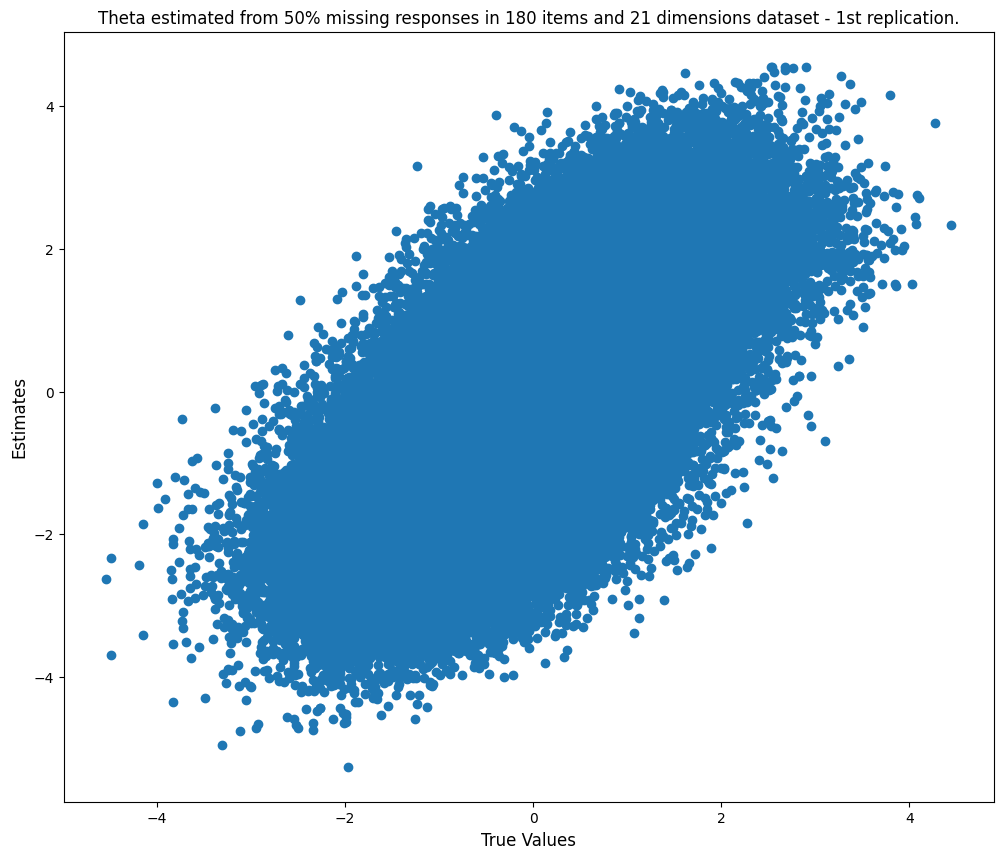

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Theta estimated from 50% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [32]:
theta_results.to_csv('output_data/50_missing/theta/theta_results.csv', sep=';', header=True, index=False)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas['Rep1'])
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
theta_df = pd.DataFrame()
theta_df['Estimate'] = thetas['Rep1']
theta_df['Dim'] = ""
theta_df['Dim'][:8000] = 1
theta_df['Dim'][8000:16000] = 2
theta_df['Dim'][16000:] = 3


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_df['Estimate'], c=theta_df['Dim'], cmap=plt.cm.Set1)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
print('1st dimension corr: %.4f' % theta_results['theta_values'][:8000].corr(theta_df['Estimate'][:8000]))
print('2nd dimension corr: %.4f' % theta_results['theta_values'][8000:16000].corr(theta_df['Estimate'][8000:16000]))
print('3rd dimension corr: %.4f' % theta_results['theta_values'][16000:].corr(theta_df['Estimate'][16000:]))

## Confusion Matrix

In [ ]:
def matrix_metrix(real_values,pred_values):
   CM = confusion_matrix(real_values,pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 

   return {'CM': CM, 
           'TN': TN,
           'FN': FN,
           'TP': TP,
           'FP': FP,
           'Population': Population,
           'Accuracy': Accuracy,
           'Precision': Precision,
           'NPV': NPV,
           'FDR': FDR,
           'FOR': FOR,
           'Recall': Recall,
           'FPR': FPR,
           'FNR': FNR,
           'TNR': TNR
           }

In [ ]:
print(confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1']))
skplt.metrics.plot_confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1'],figsize=(8,8))

In [ ]:
res = matrix_metrix(np.array(originals[0]).flatten(), binary_preds['Rep1'])

df = pd.DataFrame({'Metric': res.keys(), 'Value': res.values()})

print(df)

In [ ]:
fpr, tpr, thresholds = roc_curve(np.array(originals[0]).flatten(), preds['Rep1'])
auc = roc_auc_score(np.array(originals[0]).flatten(), preds['Rep1'])
print('AUC: %.3f' % auc)

plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(np.array(originals[0]).flatten(), preds['Rep1'])

plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Charts

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas[0]['Thetas Estimation'])
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
print(b_values.shape)
print(negative_diff.shape)

In [ ]:


fig_a = go.Figure()
fig_a.add_trace(go.Scatter(y=discr_hat, mode='lines', name='Python'))
fig_a.add_trace(go.Scatter(y=a_values.iloc[:,0], mode='lines', name='a Real'))
fig_a.update_layout( title="Discrimation")
fig_a.show()

fig_b = go.Figure()
fig_b.add_trace(go.Scatter(y=negative_diff.iloc[:,0], mode='lines', name='Python'))
fig_b.add_trace(go.Scatter(y=b_values.iloc[:,0], mode='lines', name='b Real'))
fig_b.update_layout(title="Difficulty")
fig_b.show()

fig_theta = go.Figure()
#fig_theta.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], mode='lines', name='Python'))
fig_theta.add_trace(go.Scatter(y=theta_values.iloc[:,0], mode='lines', name='Real'))
fig_theta.update_layout( title="Theta Real")
fig_theta.show()

fig_t = go.Figure()
fig_t.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], line=dict(color='green',), mode='lines', name='Python'))
#fig_t.add_trace(go.Scatter(y=theta_rep['Thetas_est'], line=dict(color='green',),mode='lines', name='R'))
fig_t.update_layout( title="Theta Hat Python")
fig_t.show()



In [ ]:
theta_values = theta_values.values.reshape((21, 10000)).transpose()

In [ ]:
print(theta_hat.shape)
print(theta_values[:N, :].flatten().shape)

In [ ]:
print(len(discr))

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values[:N, :].flatten(), y=thetas_hat)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
len(discr_hat)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=discr_hat)
#plt.colorbar()
plt.xlabel("True Values of a_values")
plt.ylabel("Estimates")
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values.values.flatten(), y=negative_diff)
#plt.colorbar()
plt.xlabel("True Values of b_values")
plt.ylabel("Estimates")
plt.show()